https://huggingface.co/spaces/wendys-llc/pdfplumber-demo

https://github.com/jsvine/nicar-2023-pdfplumber-workshop/tree/main

https://github.com/jsvine/lede-2023/tree/main/pdf-parsing

https://github.com/jsvine/pdfplumber/?tab=readme-ov-file#extracting-text

https://github.com/hananedupouy/LLMs-in-Finance/blob/main/Multimodal_llms/financial_analysis/multimodal_claude3_5_sonnet_gpt4o_claude3_opus_charts_analysis.ipynb

https://blog.knowledgator.com/extract-custom-table-from-pdf-with-llms-2ad678c26200

In [1]:
import nest_asyncio
nest_asyncio.apply()

import os
import pdfplumber

In [2]:
# pdfplumber.open("file.pdf", password = "test")
esi = pdfplumber.open('../data/esi/esi2023.pdf')

# open method above returns an instance of the pdfplumber.PDF class
print(type(esi)), print(len(esi.pages))

<class 'pdfplumber.pdf.PDF'>
414


(None, None)

In [3]:
for page in esi.pages:
    print(page.extract_text())
    break

Economic
Survey 2022-23
Government of India
Ministry of Finance
Department of Economic Affairs
Economic Division
North Block
New Delhi-110001
January, 2023


In [33]:
# create instance of pdfplumber.Page class
no = 1
page = esi.pages[no]
print(type(page))

<class 'pdfplumber.page.Page'>


In [34]:
print(dir(page))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_textmap', 'annots', 'bbox', 'cached_properties', 'chars', 'close', 'crop', 'cropbox', 'curve_edges', 'curves', 'debug_tablefinder', 'dedupe_chars', 'edges', 'extract_table', 'extract_tables', 'extract_text', 'extract_text_lines', 'extract_text_simple', 'extract_words', 'filter', 'find_table', 'find_tables', 'flush_cache', 'get_textmap', 'height', 'horizontal_edges', 'hyperlinks', 'images', 'initial_doctop', 'is_original', 'iter_layout_objects', 'layout', 'lines', 'mediabox', 'objects', 'outside_bbox', 'page_number', 'page_obj', 'pages', 'parse_objects', 'pdf', 'point2coord', 'process_object', 'rect_edges', 'rects', 'root_p

In [35]:
print(page.extract_text())

In [40]:
print(page.extract_text(layout=True))

In [41]:
# number of rectangles
type(page.rects), len(page.rects)

(list, 0)

In [42]:
# number of curved objects
len(page.curves)

0

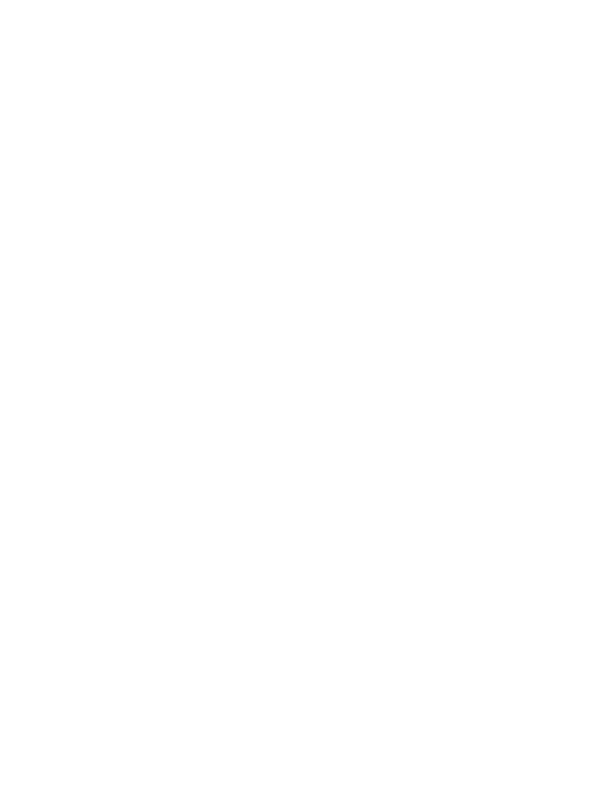

In [43]:
im = page.to_image()
im

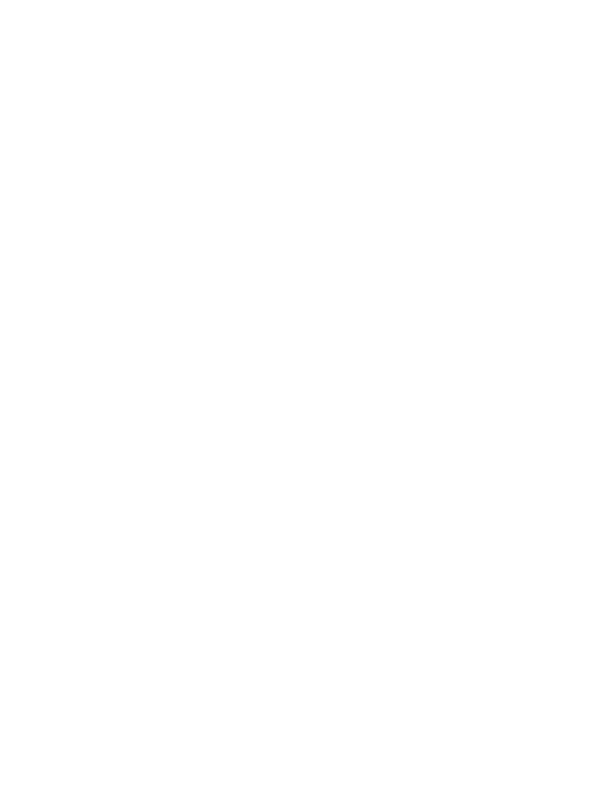

In [44]:
im.reset().draw_rects(page.chars)

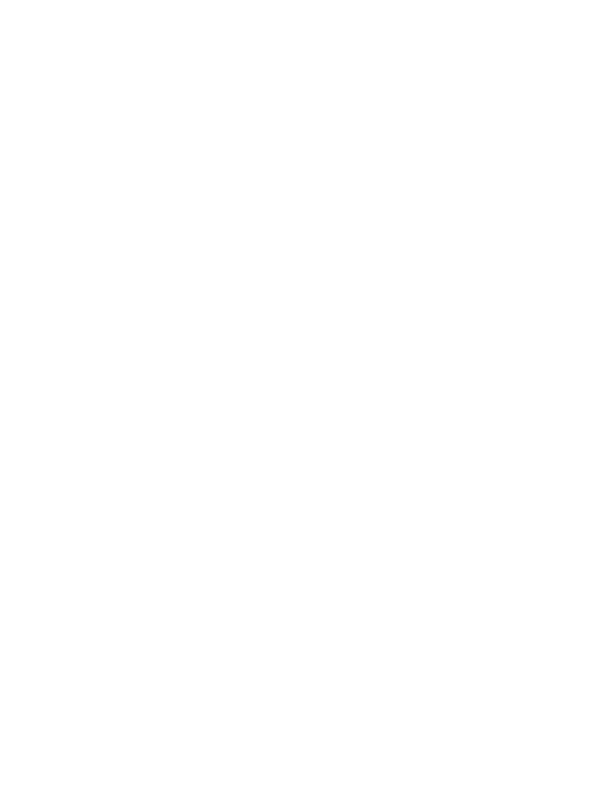

In [45]:
im.draw_rects(page.curves)

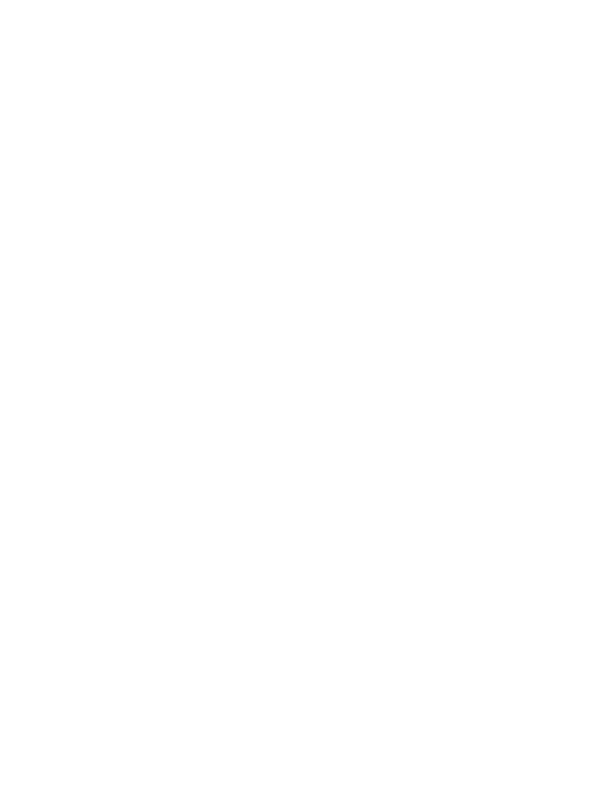

In [46]:
im.reset().debug_tablefinder()

In [47]:
page.extract_tables()

[]

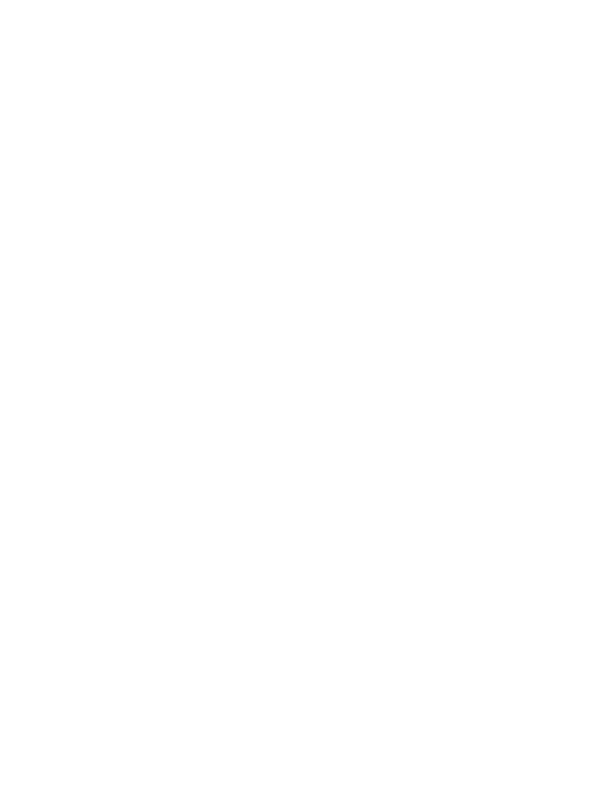

In [48]:
im.draw_rects(page.rects)

In [49]:
top_rect = page.rects[5]
top_rect_bbox = pdfplumber.utils.obj_to_bbox(top_rect)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

IndexError: list index out of range

In [50]:
print(top_rect)

NameError: name 'top_rect' is not defined

In [26]:
top_rect["x0"], top_rect["top"], top_rect["x1"], top_rect["bottom"]

(73.752, 116.1880000000001, 291.754, 298.18800000000005)

In [27]:
page.rects[5]['x1'], page.rects[6]['x0'], page.rects[1]['x1'], page.rects[2]['x0']

(291.754, 301.254, 288.751, 80.7515)

In [28]:
page.rects[1]['x1']

288.751

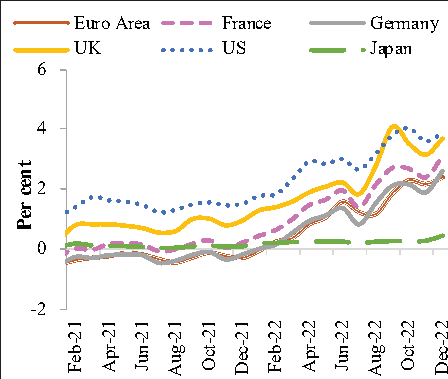

In [29]:
top_rect = page.rects[1]
top_rect_bbox = pdfplumber.utils.obj_to_bbox(top_rect)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

In [51]:
def group_adjacent_rectangles(rectangles, distance_threshold):
    """
    Group a list of rectangles into adjacent sets if the coordinates overlap or the distance between the rectangles
    is less than a specified value.
    
    Parameters:
    rectangles (list of tuples): A list of tuples where each tuple contains four integers (x1, y1, x2, y2) representing the coordinates of the bottom-left and top-right corners of a rectangle.
    distance_threshold (int): The maximum distance between rectangles to consider them as adjacent.
    
    Returns:
    list of lists of tuples: A list where each element is a list of tuples representing a group of adjacent rectangles.
    """
    def rectangles_overlap_or_close(rect1, rect2, threshold):
        # Check if rectangles overlap
        if not (rect1[2] < rect2[0] or rect1[0] > rect2[2] or rect1[3] < rect2[1] or rect1[1] > rect2[3]):
            return True
        # Check if rectangles are within the distance threshold
        if (abs(rect1[2] - rect2[0]) <= threshold or abs(rect1[0] - rect2[2]) <= threshold) and \
           (rect1[1] <= rect2[3] and rect1[3] >= rect2[1]):
            return True
        if (abs(rect1[3] - rect2[1]) <= threshold or abs(rect1[1] - rect2[3]) <= threshold) and \
           (rect1[0] <= rect2[2] and rect1[2] >= rect2[0]):
            return True
        return False

    def find_adjacent_group(rect, remaining_rects, threshold):
        group = [rect]
        to_check = [rect]
        while to_check:
            current = to_check.pop()
            for other in remaining_rects[:]:
                if rectangles_overlap_or_close(current, other, threshold):
                    group.append(other)
                    to_check.append(other)
                    remaining_rects.remove(other)
        return group

    remaining_rects = rectangles[:]
    groups = []
    while remaining_rects:
        rect = remaining_rects.pop(0)
        group = find_adjacent_group(rect, remaining_rects, distance_threshold)
        groups.append(group)
    
    return groups

# Example usage:
# rectangles = [(1, 2, 3, 4), (2, 3, 5, 6), (10, 10, 12, 12), (11, 11, 13, 13),(21,22,23,24),(22,23,24,25),(23,24,25,26)]
# rectangles = [
#     ((1, 2, 4, 5)),
#     ((2, 3, 5, 7)),
#     ((0, 1, 6, 8)),
#     ((3, 0, 7, 6)),
#     ((10, 10, 12, 12)),
#     ((-1, -2, 2, 3)),
#     ((0, 0, 3, 4)),
#     ((-2, -3, 1, 1))
# ]
rectangles = [
    (1, 2, 4, 5),
    (2, 3, 5, 7),
    (0, 1, 6, 8),
    (3, 0, 7, 6),
    (10, 10, 12, 12),
    (-1, -2, 2, 3),
    (0, 0, 3, 4),
    (-2, -3, 1, 1),
]
distance_threshold = 1
adjacent_groups = group_adjacent_rectangles(rectangles, distance_threshold)
for adj in adjacent_groups:
    print(adj)  
# Output: [[(1, 2, 3, 4), (2, 3, 5, 6)], [(10, 10, 12, 12), (11, 11, 13, 13)]]


[(1, 2, 4, 5), (2, 3, 5, 7), (0, 1, 6, 8), (3, 0, 7, 6), (-1, -2, 2, 3), (0, 0, 3, 4), (-2, -3, 1, 1)]
[(10, 10, 12, 12)]


In [60]:
# list of all rectangle objects on the page
all_rects = page.rects
print(type(all_rects), len(all_rects))
print(len(type(all_rects[0])))

<class 'list'> 0


IndexError: list index out of range

In [18]:
print(all_rects[0])# , all_rects[1]

{'x0': 290.9294, 'y0': 676.9037, 'x1': 292.2774, 'y1': 678.5287, 'width': 1.3480000000000132, 'height': 1.625, 'pts': [(292.2774, 130.47930000000008), (290.9294, 130.47930000000008), (290.9294, 132.10430000000008), (292.2774, 132.10430000000008)], 'linewidth': 0, 'stroke': False, 'fill': True, 'evenodd': False, 'stroking_color': None, 'non_stroking_color': (0, 0, 0, 1), 'mcid': None, 'tag': 'PlacedPDF', 'object_type': 'rect', 'page_number': 1, 'stroking_pattern': None, 'non_stroking_pattern': None, 'path': [('m', (292.2774, 130.47930000000008)), ('l', (290.9294, 130.47930000000008)), ('l', (290.9294, 132.10430000000008)), ('l', (292.2774, 132.10430000000008)), ('h',)], 'dash': None, 'top': 130.47930000000008, 'bottom': 132.10430000000008, 'doctop': 130.47930000000008}


In [53]:

# for i in range(len(all_rects)):
#     rect_tuple.append((all_rects[i]['x0'], all_rects[i]['y0'], all_rects[i]['x1'], all_rects[i]['y1']))

rect_tuple = []    
# Loop over the dictionary and create a tuple of rectangle box co-ordinate values from the dictionary
for i in range(len(all_rects)):
    rect_tuple.append((all_rects[i]['x0'], all_rects[i]['y0'], all_rects[i]['x1'], all_rects[i]['y1']))


In [54]:
rect_tuple1 = [(rect['x0'], rect['y0'], rect['x1'], rect['y1']) for rect in all_rects]
len(rect_tuple) == len(rect_tuple1)

True

In [55]:
# verify length equal 
len(rect_tuple) == len(all_rects)

True

In [56]:
# combine overlapping rectangles into a tuple of rectangles
distance_threshold = 5
adjacent_groups = group_adjacent_rectangles(rect_tuple, distance_threshold)
print(len(adjacent_groups))
for adj in adjacent_groups:
    print(len(adj))


0


In [57]:
# find outermost rectangle co-ordinates for each tuple of rectangles as identified above
outer_rects = []
for group in adjacent_groups:
    x0 = min(group, key=lambda x: x[0])[0]
    y0 = min(group, key=lambda x: x[1])[1]
    x1 = max(group, key=lambda x: x[2])[2]
    y1 = max(group, key=lambda x: x[3])[3]
    outer_rects.append([x0, y0, x1, y1])
    print(outer_rects)

In [26]:
print(type(outer_rects), len(outer_rects), type(outer_rects[0]))
for rect in outer_rects:
    print(rect)

<class 'list'> 1 <class 'list'>
[290.9294, 676.9037, 292.2774, 678.5287]


In [97]:
print(page.height, page.width, outer_rects[0])
page.height-outer_rects[0][1]

809.008 593.008 [73.752, 498.449, 290.753, 682.4490000000001]


310.559

In [27]:
top_rect_bbox = (outer_rects[0][0], outer_rects[0][1], outer_rects[0][2], outer_rects[0][3])
print(top_rect_bbox)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

(290.9294, 676.9037, 292.2774, 678.5287)


In [28]:
# convert each element of outer_rects to format for creating bounding box
bbox_rects = []
for rect in outer_rects:
    x0 = rect[0]
    top = page.height-rect[3]
    x1 = rect[2]
    bottom = page.height-rect[1]
    bbox_rects.append([x0, top, x1, bottom])
    

In [29]:
top_rect_bbox = (bbox_rects[0][0], bbox_rects[0][1], bbox_rects[0][2], bbox_rects[0][3])
print(top_rect_bbox)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=250)

(290.9294, 130.47930000000008, 292.2774, 132.10430000000008)


In [30]:
type(bbox_rects), len(bbox_rects), type(bbox_rects[0]), bbox_rects[0]

(list, 1, list, [290.9294, 130.47930000000008, 292.2774, 132.10430000000008])

In [44]:
#  code to check if a directory exists and create it if it doesn't
if not os.path.exists('../data/esi/test'):
    os.mkdir('../data/esi/test')
else:
    print('directory exists')

directory exists


In [46]:
# os.makedirs('../data/esi/test/images', exist_ok=True)

In [103]:
for i, rect in enumerate(bbox_rects):
    print(rect)
    bbox = (rect[0], rect[1], rect[2], rect[3])
    # print(bbox)
    bbox_cropped = page.crop(bbox)
    ia = bbox_cropped.to_image(resolution=250)
    ia.save(f'../data/esi/test/pg_{no}_img_{i+1}.png')
    

[73.752, 126.55899999999997, 290.753, 310.559]
[301.255, 126.55899999999997, 518.255, 309.521]
[71.253, 409.54900000000004, 293.253, 591.5500000000001]
[299.755, 409.54900000000004, 519.755, 591.5500000000001]


In [21]:
import time

In [26]:
start = time.time()
esi_pages = []
for num in range(len(esi.pages)):
        page = esi.pages[num]
        esi_pages.append(page.extract_text())

print(len(esi_pages))
print(time.time() - start)

414
0.017897844314575195


In [67]:
start = time.time()
esi_pages2 = [esi.pages[num].extract_text() for num in range(len(esi.pages))]

# for num in range(len(esi.pages)):
#         page = esi.pages[num]
#         esi_pages.append(page.extract_text())

print(len(esi_pages2))
print(time.time() - start)

esi_text = " ".join(esi_pages2)
print(len(esi_text))
esi_text = esi_text.replace("\n", "")
len(esi_text)

414
0.0012409687042236328
1065765


1048121

In [68]:
import re

In [69]:
target_text = "figure"
pattern = re.compile(re.escape(target_text) + r".{100}")
# pattern = re.compile(re.escape(target_text) + r".{100}")
# def replace_with_space(match):
#     return match.group(1) + " "

esi_text_clean = pattern.sub(" ", esi_text)
len(esi_text_clean)

1036781

In [70]:
print(esi_text.count('figure'))
print(esi_text_clean.count('figure'))

133
0


In [71]:
esi_text[10000:12000]

'heets were repaired and restored to health. Not letting the crisis go waste (i.e., fashioning aneffective policy response to the crisis and beyond), the government ramped up public investment in infrastructureto prepare the ground for the private sector to invest, hire and prosper. It records the wide-ranging structural reformsand governance improvements that the government has undertaken since 2014.While reforms before 2014 addressed product and capital markets, reforms since then have emphasisedenhancing the ease of living and doing business to improve economic efficiency. The key principles on which thesepolicies have been anchored are creating public goods, adopting trust-based governance, partnering with the privatesector for development and improving agricultural productivity. With cleaner, leaner and stronger balance sheetsand payoffs flowing from reforms, India’s potential growth stands elevated, and the ability of the economy to growat its potential is enhanced. Without makin

In [72]:
# write content to a text file
with open('../data/esi/test/esi_text_clean.txt', 'w') as file:
    file.write(esi_text_clean)